In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from copy import deepcopy
from typing import Tuple
import matplotlib.patches as patches
from prompt_decoder_autoreg_pl import PromptDecoder
import torch


# Define the transformation functions
def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
    """
    Compute the output size given input size and target long side length.
    """
    scale = long_side_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)

def inverse_coords(coords: np.ndarray, original_size: Tuple[int, int], target_length: int) -> np.ndarray:
    """
    Inverse transformation of coordinates from resized back to original.
    """
    old_h, old_w = original_size
    new_h, new_w = get_preprocess_shape(old_h, old_w, target_length)
    coords = deepcopy(coords).astype(float)
    coords[..., 0] = coords[..., 0] * (old_w / new_w)
    coords[..., 1] = coords[..., 1] * (old_h / new_h)
    return coords

def inverse_boxes(boxes: np.ndarray, original_size: Tuple[int, int], target_length: int) -> np.ndarray:
    """
    Inverse transformation of boxes from resized back to original.
    """
    boxes = inverse_coords(boxes.reshape(-1, 2, 2), original_size, target_length)
    return boxes.reshape(-1, 4)

def filter_labels(labels: np.ndarray) -> np.ndarray:
    """
    Filter out the first box which is all zeros and all boxes that are (-1, -1, -1, -1).
    """
    # Remove the first box if it is all zeros
    if np.all(labels[0] == 0):
        labels = labels[1:]

    # Remove boxes that are (-1, -1, -1, -1)
    labels = labels[~np.all(labels == -1, axis=1)]
    
    return labels

Number of objects:  11
Labels:
[[   0.          680.99998474  101.99999809  860.        ]
 [ 497.99999237 1843.00003052  635.99998474 1918.99993896]
 [ 886.99996948   40.99999905 1210.99998474  372.00000763]
 [1068.00003052  445.         1318.99993896  679.00001526]
 [1150.99998474 1565.         1470.         1905.        ]
 [1200.99998474 1221.99996948 1546.99996948 1565.        ]
 [1263.00003052  736.99996948 1566.00006104 1070.99998474]
 [1778.00003052    0.         2075.          128.99999619]
 [1803.00003052  385.99998474 2173.99993896  725.        ]
 [2018.99993896 1286.00006104 2305.         1558.00003052]
 [2031.00006104  873.00003052 2378.99993896 1225.        ]]


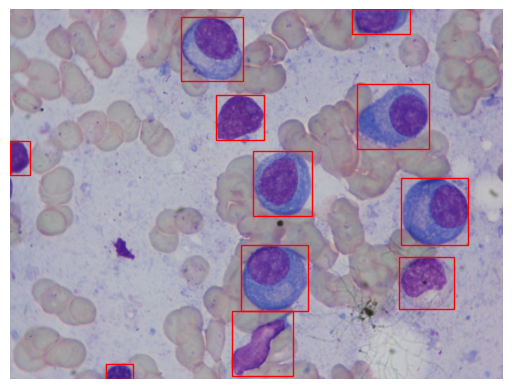

In [5]:
# File paths
index = '00001'
example_image_path = '/home/icb/hanyi.zhang/main_master_thesis/NeurIPS22-CellSeg-png/train_full/images/cell_'+index+'.png'
labels_path = '/home/icb/hanyi.zhang/main_master_thesis/NeurIPS22-CellSeg-png/train_full/labels/cell_'+index+'_label.npy'

# Read the image
image = Image.open(example_image_path)

# Get the original size of the image
original_size = image.size  # (width, height)
original_size = (original_size[1], original_size[0])  # Convert to (height, width)

# Read the labels
labels = np.load(labels_path)

# Filter the labels
filtered_labels = filter_labels(labels)

# Inverse the transformation
target_length = 1024
original_boxes = inverse_boxes(filtered_labels, original_size, target_length)
print('Number of objects: ', len(original_boxes))
print('Labels:')
print(original_boxes)

# Plot the image with bounding boxes
plt.imshow(image)
ax = plt.gca()

for box in original_boxes:
    x_min, y_min, x_max, y_max = box
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()

In [69]:
def decode_coord(model, img_emb, ref_emb, max_len, start_symbol):
    device = next(model.parameters()).device
    model.eval()

    # Convert numpy arrays to PyTorch tensors and move them to the appropriate device
    img_emb = torch.tensor(img_emb, dtype=torch.float32).to(device)
    img_emb = img_emb.unsqueeze(0)
    ref_emb = torch.tensor(ref_emb, dtype=torch.float32).to(device)
    ref_emb = ref_emb.unsqueeze(0)

    # Initialize the sequence with the start symbol
    if len(start_symbol.shape) == 2 and start_symbol.shape[1] == 4:
        decoded_coords = [coord.unsqueeze(0) for coord in start_symbol]
    else:
        decoded_coords = [start_symbol.unsqueeze(0)]

    with torch.no_grad():
        for _ in range(max_len):
            # Prepare the input for the model
            target_coord = torch.cat(decoded_coords, dim=0).unsqueeze(0).to(device)
            #print(target_coord)
            # No source mask for simplicity
            source_mask = None

            # Prepare target mask based on the current sequence length
            batch_size = 1  # During inference, batch size is 1
            diagonal = ref_emb.shape[1] + 1
            num_queries = ref_emb.shape[2] * ref_emb.shape[3] + target_coord.shape[1]
            target_mask = model.subsequent_mask(num_queries, diagonal)
            target_mask = target_mask.expand(batch_size * model.nheads, -1, -1).to(device)
            # target_mask = None

            # Decode the next coordinate
            output_coord = model.forward(
                target_coord=target_coord,
                image_embedding=img_emb,
                visual_reference_embedding=ref_emb,
                source_mask=source_mask,
                target_mask=target_mask
            )

            # Get the last predicted coordinate
            next_coord = output_coord[0, -1, :].unsqueeze(0)  # Shape: (1, 4)

            # Append the predicted coordinate to the sequence
            decoded_coords.append(next_coord)
            print(next_coord)

    # Concatenate the decoded coordinates and return as a numpy array
    decoded_coords = torch.cat(decoded_coords, dim=0).cpu().numpy()  # Convert to numpy array
    return decoded_coords


In [67]:
gt = np.load('/home/icb/hanyi.zhang/main_master_thesis/NeurIPS22-CellSeg-png/train_full/labels/cell_00001_label.npy')
print(gt[0:10])
start_symbol = torch.tensor(gt[0:5])
start_symbol

[[  0.    0.    0.    0. ]
 [  0.  272.4  40.8 344. ]
 [199.2 737.2 254.4 767.6]
 [354.8  16.4 484.4 148.8]
 [427.2 178.  527.6 271.6]
 [460.4 626.  588.  762. ]
 [480.4 488.8 618.8 626. ]
 [505.2 294.8 626.4 428.4]
 [711.2   0.  830.   51.6]
 [721.2 154.4 869.6 290. ]]


tensor([[  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000, 272.4000,  40.8000, 344.0000],
        [199.2000, 737.2000, 254.4000, 767.6000],
        [354.8000,  16.4000, 484.4000, 148.8000],
        [427.2000, 178.0000, 527.6000, 271.6000]])

In [70]:
learning_rate = 1e-2
loss_type = 'mse'
max_epochs = 500
max_num_coord = 2000
transformer_dim = 256
nheads = 4
dim_feedforward = 512
num_layers = 3
pre_norm = True
model = PromptDecoder(
    learning_rate=learning_rate,
    loss_type=loss_type,
    max_epochs=max_epochs,
    max_num_coord=max_num_coord,
    transformer_dim=transformer_dim,
    nheads=nheads,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    pre_norm=pre_norm
)

# Loads the checkpoint.
checkpoint_path = '/home/icb/hanyi.zhang/main_master_thesis/checkpoints_second_run/ObjectDetection_default-epoch=599-val_loss=0.00.ckpt'
#checkpoint_path = '/home/icb/hanyi.zhang/main_master_thesis/checkpoints_third_run/ObjectDetection_default-epoch=499-val_loss=0.06.ckpt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

# RUN THIS FOR DECODING COORDINATES
img_emb = np.load('/home/icb/hanyi.zhang/main_master_thesis/NeurIPS22-CellSeg-png/train_full/img_emb/cell_'+index+'.npy')
ref_emb = np.load('/home/icb/hanyi.zhang/main_master_thesis/NeurIPS22-CellSeg-png/train_full/ref_crop_emb/crop_cell_'+index+'.npy')
#start_symbol = torch.tensor([0, 0, 0, 0], dtype=torch.float32)
#start_symbol = torch.tensor(gt[0:2])
decoded_coords = decode_coord(model, img_emb, ref_emb, max_len=max_num_coord, start_symbol=start_symbol)

original_decoded_coords = inverse_boxes(decoded_coords, original_size, target_length)
print(original_decoded_coords)

tensor([[427.2695, 178.1183, 527.5997, 271.7205]])
tensor([[427.3390, 178.2365, 527.5995, 271.8412]])
tensor([[427.4086, 178.3545, 527.5992, 271.9620]])
tensor([[427.4784, 178.4725, 527.5988, 272.0830]])
tensor([[427.5482, 178.5904, 527.5983, 272.2044]])
tensor([[427.6181, 178.7080, 527.5980, 272.3261]])
tensor([[427.6882, 178.8254, 527.5977, 272.4482]])
tensor([[427.7582, 178.9426, 527.5977, 272.5708]])
tensor([[427.8283, 179.0593, 527.5978, 272.6941]])
tensor([[427.8984, 179.1755, 527.5983, 272.8181]])
tensor([[427.9686, 179.2912, 527.5992, 272.9431]])
tensor([[428.0387, 179.4064, 527.6009, 273.0694]])
tensor([[428.1087, 179.5205, 527.6031, 273.1971]])
tensor([[428.1786, 179.6341, 527.6061, 273.3259]])
tensor([[428.2480, 179.7474, 527.6099, 273.4554]])
tensor([[428.3168, 179.8604, 527.6146, 273.5857]])
tensor([[428.3851, 179.9734, 527.6206, 273.7169]])
tensor([[428.4526, 180.0860, 527.6281, 273.8491]])
tensor([[428.5193, 180.1984, 527.6371, 273.9824]])
tensor([[428.5853, 180.3105, 52

KeyboardInterrupt: 